# False Positive Brand Classifier - EDA & Feature Engineering

This notebook focuses on exploratory data analysis and feature engineering for the FP classifier. It compares multiple feature engineering approaches and exports the best transformer for use in model selection.

## Objective
Develop feature engineering pipeline that can distinguish between articles that genuinely mention sportswear brands vs false positives (e.g., "Puma" the animal, "Patagonia" the region).

**Key Insight: This is a recall-focused problem.**
- **Missing a real sportswear article (low recall) = BAD** - we lose the article forever
- **Letting through a false positive (low precision) = OK** - LLM can catch it later

We optimize for **F2 score** which weights recall 2x higher than precision.

## Contents
1. [Setup](#setup)
2. [Data Loading](#1-data-loading)
3. [Target Variable Analysis](#2-target-variable-analysis) (ALL DATA - for stratification)
4. [Data Preprocessing & Split](#3-data-preprocessing--split)
5. [Exploratory Data Analysis](#4-exploratory-data-analysis) (TRAINING DATA ONLY)
6. [Feature Engineering Comparison](#5-feature-engineering-comparison)
   - 5.1 [Feature Transformer Hyperparameter Tuning](#51-feature-transformer-hyperparameter-tuning)
7. [Pipeline Export](#6-pipeline-export)
8. [Summary](#7-summary)

## Setup

In [1]:
# Standard imports
import json
import sys
import warnings
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Sklearn imports
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import StratifiedKFold, cross_validate

# Add project root to path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

# Project imports
from src.fp1_nb.data_utils import (
    load_jsonl_data,
    analyze_target_stats,
    split_train_val_test,
)
from src.fp1_nb.eda_utils import (
    analyze_text_length_stats,
    plot_text_length_distributions,
    analyze_brand_distribution,
    plot_brand_distribution,
    analyze_word_frequencies,
)
from src.fp1_nb.preprocessing import (
    clean_text,
    create_text_features,
    SPORTSWEAR_VOCAB,
)
from src.fp1_nb.feature_transformer import FPFeatureTransformer
from src.fp1_nb.modeling import (
    analyze_tuning_results,
    plot_fe_comparison,
    plot_tuning_results,
    tune_feature_transformer,
)

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 100)
plt.style.use('seaborn-v0_8-whitegrid')

# Configuration
TARGET_COL = 'is_sportswear'
LABEL_NAMES = ['Not Sportswear (FP)', 'Sportswear']
TRAIN_RATIO, VAL_RATIO, TEST_RATIO = 0.6, 0.2, 0.2
RANDOM_STATE = 42
N_FOLDS = 3

# Paths
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
MODELS_DIR = project_root / 'models'
IMAGES_DIR = project_root / 'images'

# Create directories
MODELS_DIR.mkdir(exist_ok=True)
IMAGES_DIR.mkdir(exist_ok=True)

np.random.seed(RANDOM_STATE)

print("Setup complete!")

Setup complete!


## 1. Data Loading

In [2]:
# Load the FP training data
DATA_PATH = project_root / 'data' / 'fp_training_data.jsonl'
df = load_jsonl_data(DATA_PATH)

Loaded 1,047 records from fp_training_data.jsonl
Columns: ['article_id', 'title', 'content', 'brands', 'source_name', 'category', 'is_sportswear', 'source', 'fp_reason']
Memory usage: 7.53 MB


In [3]:
# Preview the data
df.head()

,article_id,title,content,brands,source_name,category,is_sportswear,source,fp_reason
0,4c227d4f-e315-4ff6-bc91-fef52fd8e732,MM6 Maison Margiela x Salomon XT - MM6 & ACS Pro Fall 2025 Release Date,"Ever since their debut collaboration in 2022 featuring the Rihanna-approved Cross Low model, MM6...",[Salomon],wwd.com,[],1,skipped,NaN
1,62df09ce-8fd1-4139-998a-5e94cfe924ef,The factors behind Lululemon CEO Calvin McDonald departure from the brand,"After seven years as CEO of athleisure giant Lululemon, retail veteran Calvin McDonald announced...",[Lululemon],insideretail.asia,[],1,labeled,NaN
2,485e193a-3f30-4f1c-855e-a947681b2cbf,Tracy McGrady Says Kobe Leaving Adidas Helped Him Get a Bigger Deal | The Complex Sneakers Podcast,"Complex's\n\nThe Complex Sneakers Show\n\nSeason 17\n\nDecember 12, 2025\n\nTracy McGrady Says K...",[Adidas],complex.com,[],1,skipped,NaN
3,10e8ecbc-0625-4aaa-b5f4-e0f4ae02527c,Where to buy Nike Air Force 1 07 Mid Flax sneakers releasing Oct . 8,"Your favorite Nike street style shoes are getting a refresh that’ll add a crisp, neutral look to...",[Nike],mlive.com,[],1,skipped,NaN
4,04a3817e-38c5-4b62-a678-6eaf49a458c5,"Prime Day competitor sales : The best deals from Walmart , Wayfair , Lululemon and other Amazon ...","As a participant in multiple affiliate marketing programs, Localish will earn a commission for c...",[Lululemon],abc7news.com,[],1,skipped,NaN


In [4]:
# Data types and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1047 entries, 0 to 1046
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   article_id     1047 non-null   object
 1   title          1047 non-null   object
 2   content        1047 non-null   object
 3   brands         1047 non-null   object
 4   source_name    1047 non-null   object
 5   category       1047 non-null   object
 6   is_sportswear  1047 non-null   int64 
 7   source         1047 non-null   object
 8   fp_reason      171 non-null    object
dtypes: int64(1), object(8)
memory usage: 73.7+ KB


In [5]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
article_id         0
title              0
content            0
brands             0
source_name        0
category           0
is_sportswear      0
source             0
fp_reason        876
dtype: int64


In [6]:
# Examine the source distribution
print("\nSource distribution:")
print(df['source'].value_counts())


Source distribution:
source
labeled           631
skipped           234
false_positive    182
Name: count, dtype: int64


## 2. Target Variable Analysis (ALL DATA)

This analysis uses the full dataset to understand class imbalance before splitting. This is necessary to inform our stratification strategy.

TARGET VARIABLE ANALYSIS

Total samples: 1,047

Class distribution:
  Not Sportswear (FP): 182 (17.4%)
  Sportswear: 865 (82.6%)

Imbalance ratio: 4.75:1

[OK] Dataset is reasonably balanced


Figure saved to images/fp_target_distribution.png


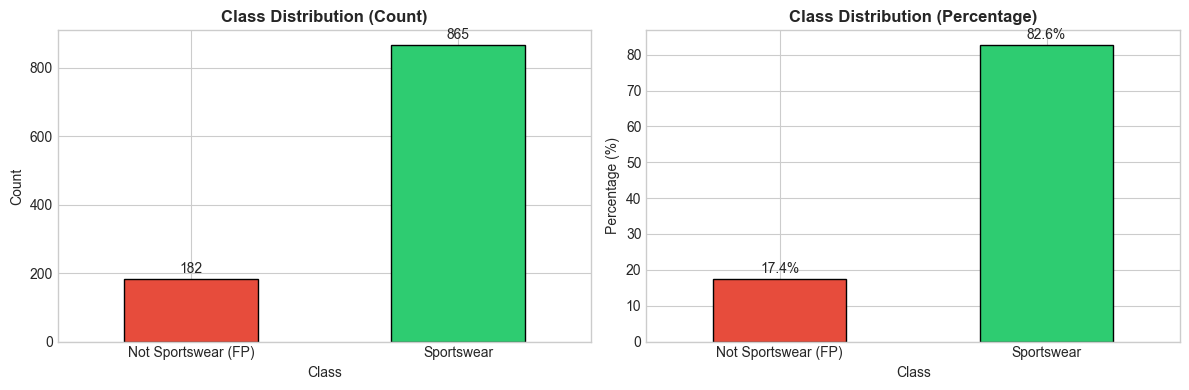

In [7]:
# Analyze target distribution
target_stats = analyze_target_stats(
    df, 
    TARGET_COL, 
    label_names=LABEL_NAMES,
    imbalance_threshold=5.0,
    save_path='images/fp_target_distribution.png'
)

## 3. Data Preprocessing & Train/Val/Test Split

We preprocess the text data first (creating text_features), then split into train/val/test sets. All subsequent EDA and feature engineering will use ONLY the training data to prevent data leakage. The validation dataset is used for feature engineering selection. The test data set is NOT used in this notebook.

In [8]:
# Create text features BEFORE splitting
# This combines title, brands, content, and metadata (source, category) into a single cleaned text field
df['text_features'] = create_text_features(
    df,
    text_col='content',
    title_col='title',
    brands_col='brands',
    source_name_col='source_name',
    category_col='category',
    include_metadata=True,
    clean_func=clean_text
)

print("Text features created!")
print(f"Sample:\n{df['text_features'].iloc[0][:300]}...")

# Check for empty text features
empty_texts = (df['text_features'].str.len() == 0).sum()
print(f"\nRecords with empty text features: {empty_texts}")
if empty_texts > 0:
    df = df[df['text_features'].str.len() > 0].copy()
    print(f"Remaining records after removing empty: {len(df)}")

Text features created!
Sample:
wwd.com mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date mm6 maison margiela salomon xt mm6 acs pro fall 2025 release date salomon ever since their debut collaboration in 2022 featuring the rihanna approved cross low model mm6 maison margiela and salomon have been frequent partners ...

Records with empty text features: 0


In [9]:
# Split with stratification
train_df, val_df, _ = split_train_val_test(
    df,
    target_col=TARGET_COL,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    random_state=RANDOM_STATE
)

# Extract features and targets
X_train = train_df['text_features']
y_train = train_df[TARGET_COL]

X_val = val_df['text_features']
y_val = val_df[TARGET_COL]

# Extract metadata for discrete metadata features
train_source_names = train_df['source_name'].tolist()
train_categories = train_df['category'].tolist()
val_source_names = val_df['source_name'].tolist()
val_categories = val_df['category'].tolist()

print(f"\nDataset sizes:")
print(f"  Train: {len(X_train)} samples")
print(f"  Val:   {len(X_val)} samples")

TRAIN/VALIDATION/TEST SPLIT

Total samples: 1,047

Split ratios: 60% / 20% / 20%

Resulting sizes:
  Train:      627 (59.9%)
  Validation: 210 (20.1%)
  Test:       210 (20.1%)

Class distribution (stratified by 'is_sportswear'):
  Train: 1: 82.6%, 0: 17.4%
  Val: 1: 82.9%, 0: 17.1%
  Test: 1: 82.4%, 0: 17.6%

Dataset sizes:
  Train: 627 samples
  Val:   210 samples


## 4. Exploratory Data Analysis (TRAINING DATA ONLY)

All EDA from this point forward uses ONLY the training data to prevent data leakage.

### 4.1 Text Length Analysis

In [10]:
# Analyze text lengths (TRAINING DATA ONLY)
text_stats = analyze_text_length_stats(train_df, 'content', TARGET_COL)

TEXT LENGTH STATISTICS

Column: 'content'
Total records: 627

Overall statistics:
  Character length: mean=3657, median=2570, range=[198, 52711]
  Word count: mean=589, median=412, range=[31, 8910]

By is_sportswear:
  Class 0:
    Chars: mean=3771, median=2715
    Words: mean=595, median=418
  Class 1:
    Chars: mean=3633, median=2534
    Words: mean=588, median=412


Figure saved to images/fp_text_length_dist.png


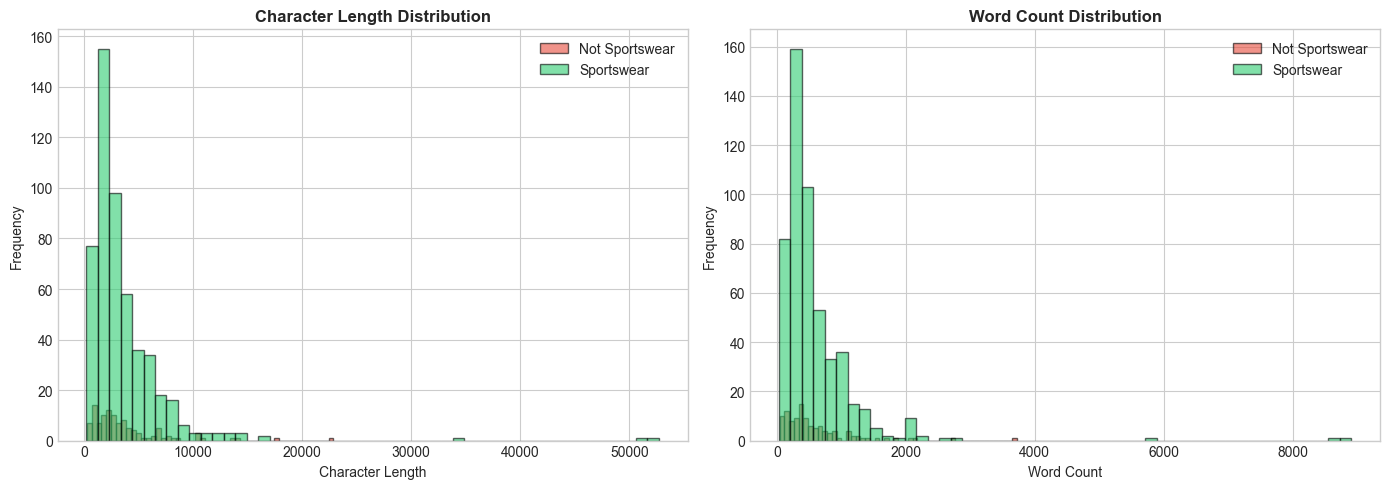

In [11]:
# Plot text length distributions by class (TRAINING DATA ONLY)
plot_text_length_distributions(
    train_df, 'content', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    save_path='images/fp_text_length_dist.png'
)

### 4.2 Brand Distribution

In [12]:
# Analyze brand distribution (TRAINING DATA ONLY)
brand_counts = analyze_brand_distribution(train_df, 'brands', TARGET_COL, top_n=15)

BRAND DISTRIBUTION

Total brand mentions: 672
Unique brands: 39

Top 15 brands:
  Nike: 168 (25.0%)
  Lululemon: 69 (10.3%)
  Puma: 42 (6.2%)
  Vans: 36 (5.4%)
  Adidas: 36 (5.4%)
  Anta: 28 (4.2%)
  Black Diamond: 24 (3.6%)
  Hoka: 23 (3.4%)
  Patagonia: 22 (3.3%)
  New Balance: 20 (3.0%)
  Skechers: 20 (3.0%)
  Timberland: 19 (2.8%)
  Converse: 17 (2.5%)
  Reebok: 17 (2.5%)
  Salomon: 12 (1.8%)

Brand distribution by is_sportswear:
  Class 0: 111 mentions, top: Vans (25), Black Diamond (23), Anta (13)
  Class 1: 561 mentions, top: Nike (167), Lululemon (69), Adidas (36)


Figure saved to images/fp_brand_dist.png


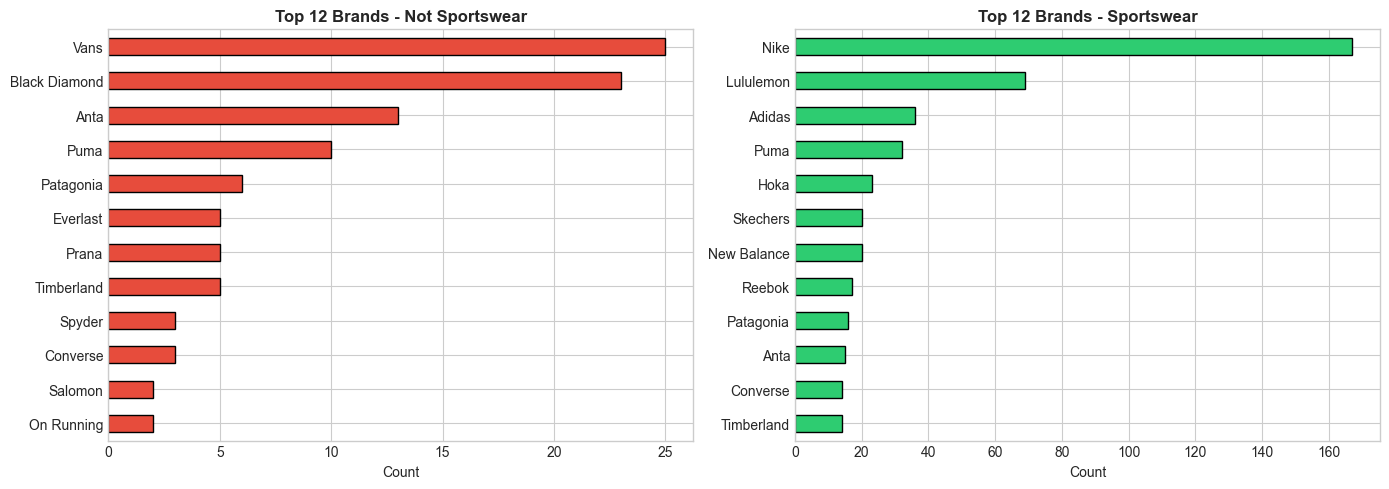

In [13]:
# Plot brand distribution by class (TRAINING DATA ONLY)
plot_brand_distribution(
    train_df, 'brands', TARGET_COL,
    label_names={0: 'Not Sportswear', 1: 'Sportswear'},
    top_n=12,
    figsize=(14, 5),
    save_path='images/fp_brand_dist.png'
)

### 4.3 Word Frequency Analysis

In [14]:
# Analyze word frequencies by class (TRAINING DATA ONLY)
word_freqs = analyze_word_frequencies(train_df, 'content', TARGET_COL, top_n=15)

WORD FREQUENCY ANALYSIS

Top 15 words for class_0:
  company: 168
  year: 110
  black: 107
  diamond: 106
  over: 104
  out: 87
  including: 83
  group: 83
  mining: 83
  vans: 81
  time: 79
  bitcoin: 79
  platform: 78
  looking: 76
  customers: 73

Top 15 words for class_1:
  nike: 1,531
  company: 1,013
  year: 866
  brand: 727
  lululemon: 648
  stock: 612
  quarter: 577
  out: 572
  shares: 548
  like: 545
  running: 532
  market: 515
  over: 503
  growth: 449
  price: 429


In [15]:
# Look at some false positive examples (TRAINING DATA ONLY)
print("\n" + "="*60)
print("SAMPLE FALSE POSITIVE ARTICLES (from training data)")
print("="*60)

fp_train = train_df[train_df[TARGET_COL] == 0]
if len(fp_train) >= 3:
    fp_samples = fp_train.sample(3, random_state=RANDOM_STATE)
else:
    fp_samples = fp_train

for _, row in fp_samples.iterrows():
    print(f"\nBrands: {row['brands']}")
    print(f"Title: {row['title'][:100]}...")
    if 'fp_reason' in row and pd.notna(row['fp_reason']):
        print(f"Reason: {row['fp_reason']}")
    print("-" * 40)


SAMPLE FALSE POSITIVE ARTICLES (from training data)

Brands: ['Timberland']
Title: Tumwater Timberland Library Reopens With a Remodel Focusing on Families , Accessibility and the Comm...
Reason: Timberland: Article is about the Timberland Regional Library system in Washington state, not Timberland footwear/apparel company
----------------------------------------

Brands: ['ASICS']
Title: AI Sparks a  DRAM Supercycle  After Years of Stagnation , Driven by Massive HBM Adoption as Big Tech...
Reason: ASICS: Article is about ASICs (Application-Specific Integrated Circuits) - semiconductor chips used in AI and computing, not ASICS the sportswear company
----------------------------------------

Brands: ['Spyder']
Title: Chevrolet Corvair Monza Spyder : The First Car with a Turbocharged Flat - Six Engine...
Reason: Spyder: Article is about the Chevrolet Corvair Monza Spyder, which is a car model/trim package from the 1960s, not Spyder sportswear/ski apparel brand
---------------------------

## 5. Feature Engineering Comparison

We compare multiple feature engineering approaches using cross-validation on the training data with a baseline Logistic Regression classifier. This helps us select the best approach before moving to model selection in the next notebook.

In [16]:
# Define feature engineering approaches to compare
fe_configs = {
    'tfidf_word': {
        'method': 'tfidf_word',
        'max_features': 10000,
        'ngram_range': (1, 2),
        'sublinear_tf': True,
    },
    'tfidf_lsa': {
        'method': 'tfidf_lsa',
        'max_features': 10000,
        'lsa_n_components': 100,
    },
    'doc2vec': {
        'method': 'doc2vec',
        'doc2vec_vector_size': 100,
        'doc2vec_min_count': 2,
        'doc2vec_epochs': 40,
        'doc2vec_dm': 1,
    },
    'sentence_transformer_ner': {
        'method': 'sentence_transformer_ner',
        'sentence_model_name': 'all-MiniLM-L6-v2',
    },
    'sentence_transformer_ner_proximity': {
        'method': 'sentence_transformer_ner_proximity',
        'sentence_model_name': 'all-MiniLM-L6-v2',
        'proximity_window_size': 15,
    },
}

# Hyperparameter tuning configurations for each method
# These define which parameter to tune and what values to try
TUNING_CONFIGS = {
    'tfidf_lsa': {
        'param_name': 'lsa_n_components',
        'param_values': [50, 60, 80, 100, 120, 150, 200],
        'description': 'LSA dimensionality'
    },
    'doc2vec': {
        'param_name': 'doc2vec_vector_size',
        'param_values': [50, 60, 80, 100, 120, 150],
        'description': 'Doc2Vec embedding dimension'
    },
    'sentence_transformer_ner': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'NER proximity window size'
    },
    'sentence_transformer_ner_proximity': {
        'param_name': 'proximity_window_size',
        'param_values': [10, 15, 20, 25, 30],
        'description': 'Proximity window size (uses corporate/outdoor vocab)'
    },
    'tfidf_word': {
        'param_name': 'max_features',
        'param_values': [5000, 6000, 8000, 10000, 12000, 15000],
        'description': 'TF-IDF vocabulary size'
    },
}

print("Feature Engineering Approaches to Compare:")
print("=" * 50)
for name, config in fe_configs.items():
    print(f"  {name}: {config['method']}")

print("\nTuning configurations defined for:")
for name in TUNING_CONFIGS:
    cfg = TUNING_CONFIGS[name]
    print(f"  {name}: {cfg['param_name']} = {cfg['param_values']}")

Feature Engineering Approaches to Compare:
  tfidf_word: tfidf_word
  tfidf_lsa: tfidf_lsa
  doc2vec: doc2vec
  sentence_transformer_ner: sentence_transformer_ner
  sentence_transformer_ner_proximity: sentence_transformer_ner_proximity

Tuning configurations defined for:
  tfidf_lsa: lsa_n_components = [50, 60, 80, 100, 120, 150, 200]
  doc2vec: doc2vec_vector_size = [50, 60, 80, 100, 120, 150]
  sentence_transformer_ner: proximity_window_size = [10, 15, 20, 25, 30]
  sentence_transformer_ner_proximity: proximity_window_size = [10, 15, 20, 25, 30]
  tfidf_word: max_features = [5000, 6000, 8000, 10000, 12000, 15000]


In [17]:
# Evaluate each feature engineering approach using cross-validation
# Compare with Logistic Regression, Random Forest, and HistGradientBoosting classifiers
f2_scorer = make_scorer(fbeta_score, beta=2)
cv = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE)

# Define classifiers to benchmark
classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(
            max_iter=2000,
            class_weight=None,
            random_state=RANDOM_STATE,
            solver='lbfgs'
        ),
        'requires_dense': False,  # LR handles sparse matrices
    },
    'RandomForest': {
        'model': RandomForestClassifier(
            n_estimators=100,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ),
        'requires_dense': False,  # RF handles sparse matrices
    },
    'HistGradientBoosting': {
        'model': HistGradientBoostingClassifier(
            max_iter=100,
            max_depth=5,
            class_weight=None,
            random_state=RANDOM_STATE,
        ),
        'requires_dense': True,  # HGB requires dense arrays
    },
}

fe_results = []

for name, config in fe_configs.items():
    print(f"Evaluating {name}...")
    
    # Create transformer
    transformer = FPFeatureTransformer(**config, random_state=RANDOM_STATE)
    
    # Fit and transform training data with metadata
    X_train_fe = transformer.fit_transform(
        X_train,
        source_names=train_source_names,
        categories=train_categories
    )
    
    print(f"  Feature shape: {X_train_fe.shape}, sparse: {sparse.issparse(X_train_fe)}")
    
    # Evaluate with each classifier
    for clf_name, clf_info in classifiers.items():
        clf = clf_info['model']
        
        # Convert to dense if classifier requires it
        if clf_info['requires_dense'] and sparse.issparse(X_train_fe):
            X_for_cv = X_train_fe.toarray()
        else:
            X_for_cv = X_train_fe
        
        # Cross-validation
        cv_scores = cross_validate(
            clf, X_for_cv, y_train,
            cv=cv,
            scoring={
                'f2': f2_scorer,
                'recall': 'recall',
                'precision': 'precision',
            },
            return_train_score=False
        )
        
        result = {
            'name': name,
            'classifier': clf_name,
            'n_features': X_train_fe.shape[1],
            'cv_f2': cv_scores['test_f2'].mean(),
            'cv_f2_std': cv_scores['test_f2'].std(),
            'cv_recall': cv_scores['test_recall'].mean(),
            'cv_precision': cv_scores['test_precision'].mean(),
        }
        fe_results.append(result)
        
        print(f"  [{clf_name}] CV F2: {result['cv_f2']:.4f} (+/- {result['cv_f2_std']:.4f})")

Evaluating tfidf_word...


  Feature shape: (627, 10008), sparse: True


  [LogisticRegression] CV F2: 0.9588 (+/- 0.0025)


  [RandomForest] CV F2: 0.9693 (+/- 0.0016)


  [HistGradientBoosting] CV F2: 0.9576 (+/- 0.0066)
Evaluating tfidf_lsa...


  Feature shape: (627, 108), sparse: False
  [LogisticRegression] CV F2: 0.9618 (+/- 0.0011)


  [RandomForest] CV F2: 0.9711 (+/- 0.0014)


  [HistGradientBoosting] CV F2: 0.9580 (+/- 0.0045)
Evaluating doc2vec...


  Feature shape: (627, 108), sparse: False
  [LogisticRegression] CV F2: 0.9358 (+/- 0.0023)


  [RandomForest] CV F2: 0.9622 (+/- 0.0056)


  [HistGradientBoosting] CV F2: 0.9610 (+/- 0.0009)
Evaluating sentence_transformer_ner...


  Feature shape: (627, 398), sparse: False
  [LogisticRegression] CV F2: 0.9599 (+/- 0.0082)


  [RandomForest] CV F2: 0.9668 (+/- 0.0046)


  [HistGradientBoosting] CV F2: 0.9617 (+/- 0.0053)
Evaluating sentence_transformer_ner_proximity...


  Feature shape: (627, 406), sparse: False
  [LogisticRegression] CV F2: 0.9590 (+/- 0.0075)


  [RandomForest] CV F2: 0.9686 (+/- 0.0087)


  [HistGradientBoosting] CV F2: 0.9648 (+/- 0.0094)


In [18]:
# Compare feature engineering results
fe_df = pd.DataFrame(fe_results)

# Create pivot table for easier comparison
pivot_df = fe_df.pivot_table(
    index='name',
    columns='classifier',
    values=['cv_f2', 'cv_recall', 'cv_precision'],
    aggfunc='first'
)

print("\n" + "=" * 80)
print("FEATURE ENGINEERING COMPARISON RESULTS")
print("=" * 80)

# Display results sorted by F2 score for each classifier
for clf_name in ['LogisticRegression', 'RandomForest', 'HistGradientBoosting']:
    clf_df = fe_df[fe_df['classifier'] == clf_name].set_index('name')
    clf_df = clf_df.sort_values('cv_f2', ascending=False)
    print(f"\n{clf_name} Results:")
    print(clf_df[['n_features', 'cv_f2', 'cv_f2_std', 'cv_recall', 'cv_precision']])

print("=" * 80)

# Determine best overall
best_row = fe_df.loc[fe_df['cv_f2'].idxmax()]
best_fe = best_row['name']
best_clf = best_row['classifier']
print(f"\nBest combination: {best_fe} + {best_clf}")
print(f"  CV F2: {best_row['cv_f2']:.4f}")
print(f"  Features: {int(best_row['n_features'])}")


FEATURE ENGINEERING COMPARISON RESULTS

LogisticRegression Results:
                                    n_features     cv_f2  cv_f2_std  \
name                                                                  
tfidf_lsa                                  108  0.961752   0.001064   
sentence_transformer_ner                   398  0.959876   0.008204   
sentence_transformer_ner_proximity         406  0.958960   0.007523   
tfidf_word                               10008  0.958821   0.002522   
doc2vec                                    108  0.935812   0.002260   

                                    cv_recall  cv_precision  
name                                                         
tfidf_lsa                            1.000000      0.834151  
sentence_transformer_ner             0.971042      0.918285  
sentence_transformer_ner_proximity   0.965273      0.934580  
tfidf_word                           0.998062      0.828523  
doc2vec                              0.934366      0.941665  

Figure saved to /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fe_comparison.png


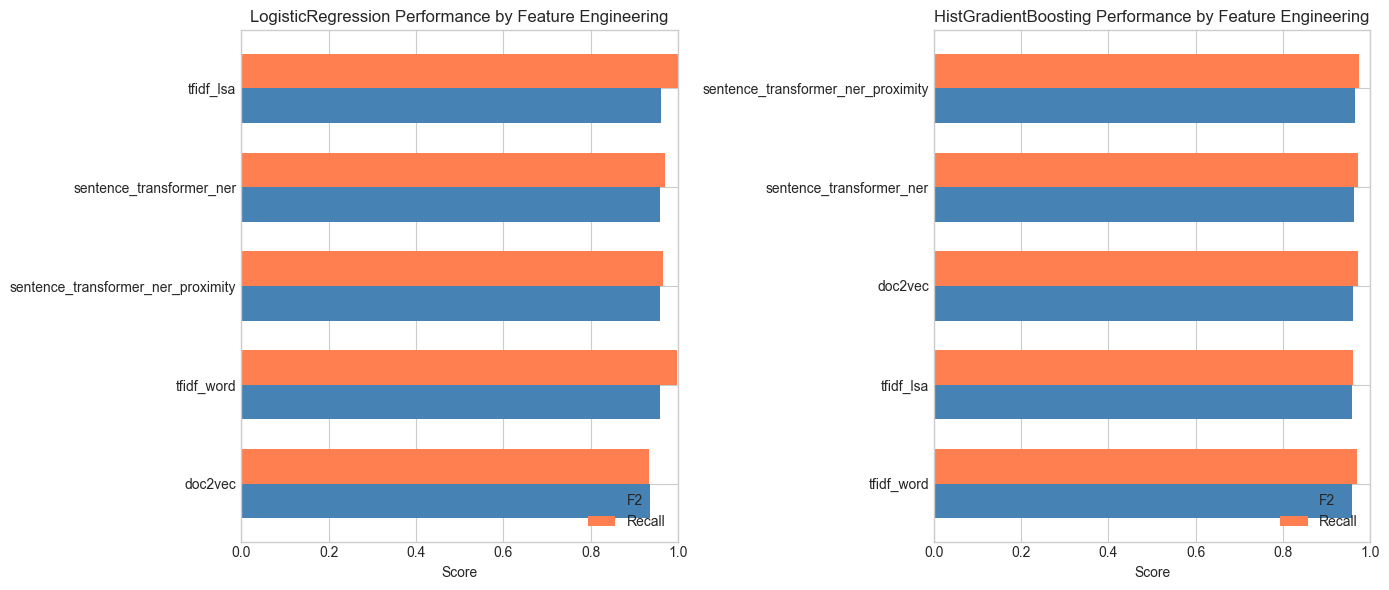

In [19]:
# Visualize comparison - show both classifiers side by side
plot_fe_comparison(fe_df, save_path=MODELS_DIR / 'fe_comparison.png')

## 5.1 Feature Transformer Hyperparameter Tuning

Based on the comparison results above, we tune the key hyperparameter for the best-performing feature engineering method. Each method has a primary hyperparameter that affects its feature representation quality.

In [20]:
# Choose the baseline classifier to use
baseline_clf = classifiers['HistGradientBoosting']['model']

# Check if tuning configuration exists for the best method
if best_fe in TUNING_CONFIGS:
    tuning_config = TUNING_CONFIGS[best_fe]
    param_name = tuning_config['param_name']
    param_values = tuning_config['param_values']
    
    print("=" * 70)
    print(f"TUNING {param_name.upper()} FOR {best_fe}")
    print("=" * 70)
    print(f"\nTesting values: {param_values}")
    print(f"Classifier: HistGradientBoostingClassifier (baseline)")
    print(f"CV: {N_FOLDS}-fold stratified\n")
    
    tuning_df = tune_feature_transformer(
        transformer_class=FPFeatureTransformer,
        base_config=fe_configs[best_fe],
        param_name=param_name,
        param_values=param_values,
        X_train=X_train,
        y_train=y_train,
        classifier=baseline_clf,
        cv=cv,
        scorer=f2_scorer,
        train_source_names=train_source_names,
        train_categories=train_categories,
        random_state=RANDOM_STATE,
    )
    
    print("\n" + "=" * 70)
    
    # Analyze tuning results and select best hyperparameter value
    if tuning_df is not None:
        default_value = fe_configs[best_fe].get(param_name)
        
        optimal_param_value, best_tuned_f2 = analyze_tuning_results(
            tuning_df=tuning_df,
            param_name=param_name,
            default_value=default_value,
        )   
    else:
        optimal_param_value = None
else:
    print(f"No tuning configuration defined for {best_fe}")
    print("No tuning was performed.")
    tuning_df = None

TUNING LSA_N_COMPONENTS FOR tfidf_lsa

Testing values: [50, 60, 80, 100, 120, 150, 200]
Classifier: HistGradientBoostingClassifier (baseline)
CV: 3-fold stratified

Testing lsa_n_components=50...


  CV F2: 0.9540 (+/- 0.0189)
Testing lsa_n_components=60...


  CV F2: 0.9613 (+/- 0.0136)
Testing lsa_n_components=80...


  CV F2: 0.9626 (+/- 0.0066)
Testing lsa_n_components=100...


  CV F2: 0.9580 (+/- 0.0045)
Testing lsa_n_components=120...


  CV F2: 0.9534 (+/- 0.0058)
Testing lsa_n_components=150...


  CV F2: 0.9603 (+/- 0.0063)
Testing lsa_n_components=200...


  CV F2: 0.9541 (+/- 0.0110)

LSA_N_COMPONENTS TUNING RESULTS
 lsa_n_components    cv_f2  cv_f2_std  cv_recall  cv_precision
               80 0.962597   0.006604   0.963324      0.960133
               60 0.961341   0.013646   0.963268      0.954492
              150 0.960320   0.006263   0.963302      0.948842
              100 0.958043   0.004507   0.961375      0.945155
              200 0.954136   0.010966   0.957488      0.941420
               50 0.953979   0.018873   0.955538      0.948333
              120 0.953350   0.005794   0.955572      0.944976

Optimal lsa_n_components: 80
Best CV F2: 0.9626
Default (100) CV F2: 0.9580
Improvement: +0.46%


## 6. Pipeline Export

Create and export the best feature transformer for use in the model selection notebook.

In [21]:
# Create the best transformer with optimal hyperparameters from tuning
print(f"Selected feature engineering approach: {best_fe}")
print(f"Base configuration: {fe_configs[best_fe]}")

# Create final config with optimal hyperparameters
final_config = fe_configs[best_fe].copy()
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    final_config[param_name] = optimal_param_value
    print(f"Optimal {param_name}: {optimal_param_value}")

# Create transformer with best configuration INCLUDING tuned hyperparameters
final_transformer = FPFeatureTransformer(**final_config, random_state=RANDOM_STATE)

# Fit on training data with metadata
X_train_final = final_transformer.fit_transform(
    X_train,
    source_names=train_source_names,
    categories=train_categories
)
print(f"\nFinal feature shape: {X_train_final.shape}")
print(f"Metadata features enabled: {final_transformer.include_metadata_features}")
print(f"Metadata scaler fitted: {final_transformer._metadata_scaler is not None}")

# Verify by transforming validation data
X_val_final = final_transformer.transform(
    X_val,
    source_names=val_source_names,
    categories=val_categories
)
print(f"Validation feature shape: {X_val_final.shape}")

Selected feature engineering approach: tfidf_lsa
Base configuration: {'method': 'tfidf_lsa', 'max_features': 10000, 'lsa_n_components': 100}
Optimal lsa_n_components: 80



Final feature shape: (627, 88)
Metadata features enabled: True
Metadata scaler fitted: True
Validation feature shape: (210, 88)


In [22]:
# Save the fitted transformer
transformer_path = MODELS_DIR / 'fp_feature_transformer.joblib'
joblib.dump(final_transformer, transformer_path)
print(f"Transformer saved to: {transformer_path}")

# Save configuration for reproducibility
config_path = MODELS_DIR / 'fp_feature_config.json'
final_transformer.save_config(config_path)
print(f"Configuration saved to: {config_path}")

# Also save the comparison results
results_path = MODELS_DIR / 'fp_fe_comparison.json'
with open(results_path, 'w') as f:
    json.dump(fe_results, f, indent=2)
print(f"Comparison results saved to: {results_path}")

Transformer saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
Configuration saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
Comparison results saved to: /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json


## 7. Summary

In [23]:
print("=" * 60)
print("NOTEBOOK SUMMARY")
print("=" * 60)
print(f"\nDataset: {len(df)} articles")
print(f"  - Training: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
print(f"  - Validation: {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
print(f"\nClass distribution (training):")
print(f"  - Sportswear: {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")
print(f"  - False Positive: {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"\nBest Feature Engineering: {best_fe}")
print(f"  - Best Classifier: {best_clf}")
print(f"  - CV F2 Score: {best_row['cv_f2']:.4f}")
print(f"  - Features: {int(best_row['n_features'])}")

# Show tuned hyperparameter if applicable
if best_fe in TUNING_CONFIGS and optimal_param_value is not None:
    param_name = TUNING_CONFIGS[best_fe]['param_name']
    print(f"  - Optimal {param_name}: {optimal_param_value}")

print(f"\nArtifacts saved:")
print(f"  - {MODELS_DIR / 'fp_feature_transformer.joblib'}")
print(f"  - {MODELS_DIR / 'fp_feature_config.json'}")
print(f"  - {MODELS_DIR / 'fp_fe_comparison.json'}")
print(f"\nNext: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning")
print("=" * 60)

NOTEBOOK SUMMARY

Dataset: 1047 articles
  - Training: 627 (59.9%)
  - Validation: 210 (20.1%)

Class distribution (training):
  - Sportswear: 518 (82.6%)
  - False Positive: 109 (17.4%)

Best Feature Engineering: tfidf_lsa
  - Best Classifier: RandomForest
  - CV F2 Score: 0.9711
  - Features: 108
  - Optimal lsa_n_components: 80

Artifacts saved:
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_transformer.joblib
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_feature_config.json
  - /home/fdpearce/Documents/Courses/DataTalksClub/projects/machine-learning-zoomcamp/sportswear-esg-news-classifier/models/fp_fe_comparison.json

Next: Run fp2_model_selection_tuning.ipynb for model selection and hyperparameter tuning
